In [2]:


from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"

filename = os.path.join(path,"crx.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
encode_numeric_zscore(df,'a2')
encode_numeric_zscore(df,'s3')
encode_numeric_zscore(df,'a8')
encode_numeric_zscore(df,'a11')
encode_numeric_zscore(df,'a14')
encode_numeric_zscore(df,'a15')
encode_text_dummy(df, 'a1')
encode_text_dummy(df, 'a4')
encode_text_dummy(df, 'a5')
encode_text_dummy(df, 'a6')
encode_text_dummy(df, 'a7')
encode_text_dummy(df, 'a9')
encode_text_dummy(df, 'a10')
encode_text_dummy(df, 'a12')
encode_text_dummy(df, 'a13')
encode_text_dummy(df, 'a9')
missing_median(df, 'a2')
missing_median(df, 'a14')
species = encode_text_index(df,"a16")
a16 = encode_text_index(df,'a16')
num_classes = len(a16)



# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'a16')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Using TensorFlow backend.


FileNotFoundError: File b'./data/crx.csv' does not exist

In [ ]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_compare, pred)
print("Final accuracy: {}".format(score))

Confusion matrix, without normalization
[[74  8]
 [ 5 86]]
Normalized confusion matrix
[[ 0.9   0.1 ]
 [ 0.05  0.95]]


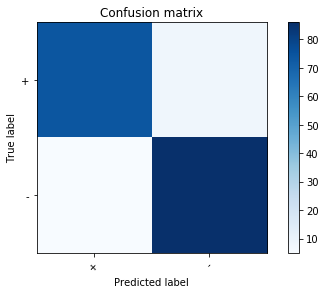

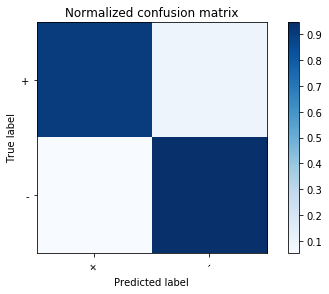

In [10]:

import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, species)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, species, title='Normalized confusion matrix')

plt.show()

In [ ]:
# The data set I choose is the Credit Approval Data Set（CRX）which concerns credit card application. I train it for a classification, and chose the attribute a16 as the prediction field.
# 
# 1. How did you encode the input variables?
# 1>a2,s3,a8,a11,a14,a15 are encoded using the zscore function because these attributes are numeric values and could be made more comprehensible.
# 2>a1,a4,a5,a6,a7,a9,a10,a12,a13 are encoded using the encode_text_dummy function, because these attributes are text field and are non-targeted attributes.
# 3>a2,a14 have some missing values, so they are encoded using missing_median function for filling the missing spaces with the related median value.
# 4>a16 is the chosen the target field, so it is encoded using encode_text_index function for encoding targeted text field.
# 
# 2. How did you choose how to evaluate the accuracy of your model?
# Log Loss is chosen here for evaluating the accuracy of the model.  Neural network can predict a probability for each of the target classes, which may give high probabilities to predictions that are more close relative, which needs Log loss to penalize confidence in wrong answers. 
# 
# 3. Why is your model either classification or regression?
# My model is for classification.
# 
# 4. Were there any missing data? How did you handle it?
# Yes. In this set, a2&a14 have missing values.
# missing_median function is used to convert all missing values in the specified column to the related median.
# 
# 
# 5. Mention any other challenges or difficulties you had with the dataset. 
# 1>When the csv data set is first seen, it looks intricate since there is no direct explainations on website.  What is the meaning of each column is complicated.
# 2>Since the raw data was not preprocessed, it was difficult to make compare to get  meaningful information.  And the data has to be processed first since the input to neural network must be completely numeric.
# 3>I have to try to increase the accuracy of my model, like trying to increase steps of training, or increase the number of the hidden layer's parameters to train.

